In [1]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.3f}'.format

# 0. Functions 

### 0.1. Encoding functions

In [2]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
############################################################

### 0.2. Split Data Function

In [3]:
def train_valid_sets(X_train_set, X_valid_set):
    #######################################
    ### SPLIT DATA
    #######################################
    train_set = X_train_set
    valid_set = X_valid_set

    print('total admissions 16 18', len(X_train_set))
    print('total admissions 19 20', len(X_valid_set))
    print('X_train', len(train_set))
    print('Admissions neg (mortal - class = 0):', len(train_set[train_set['Mortality']==0]),
          'Admissions pos (recover- class = 1):', len(train_set[train_set['Mortality']==1]))
    print('X_valid', len(valid_set))
    print('Admissions neg (mortal - class = 0):', len(valid_set[valid_set['Mortality']==0]), 
          'Admissions pos (recover- class = 1):', len(valid_set[valid_set['Mortality']==1]))
    return train_set, valid_set

### 0.3. Encoding Data Function

In [4]:
def encoding_data(train_set, valid_set, feat_list, data_types):
    ############################################################
    train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
    valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)
    print("==========================================================================================================")
    print('----------------------------------TRAIN SET---------------------------------------------------------------')
    print("==========================================================================================================")
    display(train_set.head(4))
    display(train_set_norm.head(4))
    print("==========================================================================================================")
    print('----------------------------------VALIDATION SET----------------------------------------------------------')
    print("==========================================================================================================")
    display(valid_set.head(4))
    display(valid_set_norm.head(4))
    display(encoder)
    return train_set_norm, valid_set_norm, encoder

# 1. Load Data

In [5]:
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

X_data_16_18 = pickle.load(open(path + 'df_first_curb_2016_18.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_first_curb_2019_20.pickle','rb'))


print("=================================FIRST RECORDED SAMPLE ADMISSION=================================")
print("-------------------------------------- 2016 - 2018 ----------------------------------------------")
display(X_data_16_18[0].head(3))
print("")
print("-------------------------------------- 2019 - 2020 ----------------------------------------------")
display(X_data_19_20[0].head(3))

print("Elapsed time:", time.time()-t)

=================================FIRST RECORDED SAMPLE ADMISSION=================================
-------------------------------------- 2016 - 2018 ----------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,38552641,34.000,11,118.000,39.200,100.000,55.000,96.000,1.000,0,-1,3,54,2,1,1.000,0
144,37660212,24.000,7,75.000,37.000,100.000,54.000,95.000,1.000,0,-1,0,47,0,0,0.000,0
288,67150633,24.000,4,75.000,37.800,117.000,72.000,92.000,1.000,1,-1,0,84,8,0,0.000,0



-------------------------------------- 2019 - 2020 ----------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,25298427,18.000,3,88.000,37.000,76.000,54.000,100.000,0.000,0,-1,0,64,6,0,1.000,0
144,31669457,22.000,9,135.000,38.500,148.000,97.000,95.000,1.000,0,-1,0,36,0,0,0.000,0
288,52534553,16.000,2,66.000,37.100,136.000,84.000,100.000,1.000,0,1,1,84,3,0,0.000,0


Elapsed time: 0.19904780387878418


In [6]:
feat_list = X_data_16_18[0].columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 15


In [7]:
# Loading the CSV with types
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

In [8]:
############################################################
# Results DataFrame Creation
############################################################

# Modelling parameters SVM Classfier

In [9]:
from sklearn import svm
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

t = time.time()
# define model
model = svm.SVC(kernel='rbf', probability = True, random_state = 0, max_iter = 1000000)
# define grid
weights = [{1:1}, {1:2}, {1:3}, {1:4},{1:5},{1:8},{1:10}, {1:25},{1:50},{1:75},{1:99},{1:100},{1:500}]
param_grid = dict(class_weight =weights)
scoring = {"AUC": "roc_auc", "Recall": "recall"}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scoring, refit = "Recall")

# 2. Modelling SVM classifier

In [10]:
def train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list):
    df_results_train = pd.DataFrame()
    df_results       = pd.DataFrame()
    dict_fpr_tpr     = {}
    X_train = np.array(train_set[feat_list]); Y_train = np.array(X_train_set['Mortality'])
    X_valid = np.array(valid_set[feat_list]); Y_valid = np.array(X_valid_set['Mortality'])
    #################################################################
    #################################################################
    # TRAINING THE MODEL
    #################################################################
    t = time.time()
    # execute the grid search
    grid_result = grid.fit(X_train, Y_train)
    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # report all configurations
    auc_means = grid_result.cv_results_['mean_test_AUC']
    rcl_means = grid_result.cv_results_['mean_test_Recall']
    params    = grid_result.cv_results_['params']
    print("AUC    (call)")
    for mean, rcl, param in zip(auc_means, rcl_means, params):
        print("%f (%f) with: %r" % (mean, rcl, param))    
    df_results_train['NoF_auc'] = auc_means
    df_results_train['NoF_rcl'] = rcl_means
    print("")
    print("time elapased training: ", time.time()-t)
    #################################################################
    #################################################################
    # results - Model Validation
    #################################################################

    y_scores  = grid.predict(X_valid)
    y_predict = FineTuning.adjusted_classes(y_scores, 0.5)
    y_proba   = grid.predict_proba(X_valid)[:,1]
    df_results, fpr_tpr = LearningCurves.results_precision_recall_cm(Y_valid, y_predict, y_proba, fig_size = None)
    plt.show()
    dict_fpr_tpr['NoF'] = fpr_tpr
    df_results = df_results.set_index(pd.Series('NoF'))
    display(df_results)
    return [df_results_train, df_results, dict_fpr_tpr]

# CURB65 Group 1

In [11]:
X_train_set = X_data_16_18[0]
X_valid_set = X_data_19_20[0]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1161
total admissions 19 20 409
X_train 1161
Admissions neg (mortal - class = 0): 1110 Admissions pos (recover- class = 1): 51
X_valid 409
Admissions neg (mortal - class = 0): 378 Admissions pos (recover- class = 1): 31

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,38552641,34.000,11,118.000,39.200,100.000,55.000,96.000,1.000,0,-1,3,54,2,1,1.000,0
144,37660212,24.000,7,75.000,37.000,100.000,54.000,95.000,1.000,0,-1,0,47,0,0,0.000,0
288,67150633,24.000,4,75.000,37.800,117.000,72.000,92.000,1.000,1,-1,0,84,8,0,0.000,0
432,69761415,19.000,3,98.000,36.200,133.000,57.000,98.000,1.000,0,1,0,93,3,1,1.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,3.073,0.000,1.050,1.977,-1.377,-1.550,0.342,1.000,0,-1,0.017,-0.425,0.022,1,1.000
144,0.598,0.083,-1.212,-0.436,-1.377,-1.626,0.057,1.000,0,-1,0.050,-0.833,-0.595,0,0.000
288,0.598,0.035,-1.212,0.441,-0.572,-0.261,-0.796,1.000,1,-1,0.050,1.323,1.871,0,0.000
432,-0.639,0.016,-0.002,-1.314,0.185,-1.399,0.911,1.000,0,1,0.050,1.847,0.330,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,25298427,18.000,3,88.000,37.000,76.000,54.000,100.000,0.000,0,-1,0,64,6,0,1.000,0
144,31669457,22.000,9,135.000,38.500,148.000,97.000,95.000,1.000,0,-1,0,36,0,0,0.000,0
288,52534553,16.000,2,66.000,37.100,136.000,84.000,100.000,1.000,0,1,1,84,3,0,0.000,0
432,21124330,20.000,4,91.000,37.100,123.000,76.000,94.000,1.000,0,1,0,67,0,0,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.887,0.016,-0.528,-0.436,-2.513,-1.626,1.480,0.000,0,-1,0.050,0.157,1.255,0,1.000
144,0.103,0.033,1.944,1.209,0.895,1.634,0.057,1.000,0,-1,0.050,-1.474,-0.595,0,0.000
288,-1.381,0.038,-1.685,-0.327,0.327,0.648,1.480,1.000,0,1,0.045,1.323,0.330,0,0.000
432,-0.392,0.035,-0.370,-0.327,-0.288,0.042,-0.227,1.000,0,1,0.050,0.332,-0.595,0,1.000


,feature,type,parameters
0,rr,Continuous,"[21.58268733850129, 4.041120749237411]"
1,ews,Categorical,0 1 prob 11 3 0 0.000 7 77 7 0...
2,heart_rate,Continuous,"[98.03990812517944, 19.012290233291814]"
3,temperature,Continuous,"[37.3977318403675, 0.9114084425224606]"
4,sbp,Continuous,"[129.08986505885733, 21.12805922601554]"
5,dbp,Continuous,"[75.44846396784382, 13.188692830136354]"
6,Oxygen_Saturation,Continuous,"[94.7985931668102, 3.5140439274566604]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############
Best: 1.000000 using {'class_weight': {1: 75}}
AUC    (call)
0.575856 (0.000000) with: {'class_weight': {1: 1}}
0.612332 (0.000000) with: {'class_weight': {1: 2}}
0.634575 (0.000000) with: {'class_weight': {1: 3}}
0.661231 (0.000000) with: {'class_weight': {1: 4}}
0.694084 (0.000000) with: {'class_weight': {1: 5}}
0.709499 (0.000000) with: {'class_weight': {1: 8}}
0.706146 (0.000000) with: {'class_weight': {1: 10}}
0.671722 (0.646667) with: {'class_weight': {1: 25}}
0.660420 (0.966667) with: {'class_weight': {1: 50}}
0.621081 (1.000000) with: {'class_weight': {1: 75}}
0.624615 (1.000000) with: {'class_weight': {1: 99}}
0.625155 (1.000000) with: {'class_weight': {1: 100}}
0.649880 (1.000000) with: {'class_weight': {1: 500}}

time elapased training:  68.41899490356445


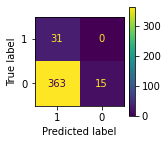

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.079,1.000,0.146,0.112,0.567,0.070


In [12]:
print("############### Results without encoding ##############")
results1     = train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list)

############### Results encoded data ##############
Best: 0.257778 using {'class_weight': {1: 25}}
AUC    (call)
0.664394 (0.000000) with: {'class_weight': {1: 1}}
0.672292 (0.000000) with: {'class_weight': {1: 2}}
0.689459 (0.038889) with: {'class_weight': {1: 3}}
0.689439 (0.098889) with: {'class_weight': {1: 4}}
0.684384 (0.137778) with: {'class_weight': {1: 5}}
0.677147 (0.184444) with: {'class_weight': {1: 8}}
0.677598 (0.231111) with: {'class_weight': {1: 10}}
0.670561 (0.257778) with: {'class_weight': {1: 25}}
0.670561 (0.257778) with: {'class_weight': {1: 50}}
0.670561 (0.257778) with: {'class_weight': {1: 75}}
0.670561 (0.257778) with: {'class_weight': {1: 99}}
0.670561 (0.257778) with: {'class_weight': {1: 100}}
0.670561 (0.257778) with: {'class_weight': {1: 500}}

time elapased training:  24.595905542373657


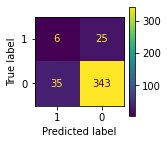

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.146,0.194,0.167,0.853,0.611,0.070


In [13]:
print("############### Results encoded data ##############")
results1_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, X_train_set, X_valid_set, grid, feat_list)

# CURB65 Group 2

In [14]:
X_train_set = X_data_16_18[1]
X_valid_set = X_data_19_20[1]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1037
total admissions 19 20 389
X_train 1037
Admissions neg (mortal - class = 0): 926 Admissions pos (recover- class = 1): 111
X_valid 389
Admissions neg (mortal - class = 0): 328 Admissions pos (recover- class = 1): 61

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,97068612,20.000,1,97.000,37.300,115.000,72.000,96.000,1.000,1,1,0,84,0,1,1.000,0
144,73017510,22.000,10,66.000,36.000,95.000,60.000,96.000,1.000,1,-1,0,90,0,1,1.000,1
288,76521119,23.000,8,82.000,37.300,103.000,67.000,90.000,1.000,0,-1,0,72,9,0,0.000,1
432,92549820,19.000,1,92.000,37.200,142.000,70.000,88.000,1.000,0,-1,0,79,6,1,1.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.493,0.066,0.138,0.113,-0.555,0.029,0.462,1.000,1,1,0.114,0.616,-0.815,1,1.000
144,-0.082,0.219,-1.427,-1.387,-1.413,-0.798,0.462,1.000,1,-1,0.114,1.150,-0.815,1,1.000
288,0.123,0.129,-0.619,0.113,-1.070,-0.316,-1.082,1.000,0,-1,0.114,-0.451,0.841,0,0.000
432,-0.698,0.066,-0.114,-0.002,0.604,-0.109,-1.597,1.000,0,-1,0.114,0.171,0.289,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,88572864,16.000,6,73.000,34.900,90.000,44.000,96.000,0.000,1,-1,1,93,6,1,1.000,1
144,62751181,24.000,7,114.000,39.000,137.000,81.000,98.000,1.000,0,1,0,67,0,0,1.000,0
288,21357495,24.000,2,71.000,37.900,150.000,66.000,96.000,0.000,0,-1,0,84,8,1,1.000,0
432,83262936,16.000,1,87.000,36.800,137.000,72.000,95.000,0.000,0,1,0,89,0,0,1.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-1.314,0.108,-1.074,-2.656,-1.628,-1.901,0.462,0.000,1,-1,0.091,1.417,0.289,1,1.000
144,0.329,0.094,0.997,2.075,0.389,0.649,0.976,1.000,0,1,0.114,-0.896,-0.815,0,1.000
288,0.329,0.147,-1.175,0.805,0.947,-0.385,0.462,0.000,0,-1,0.114,0.616,0.657,1,1.000
432,-1.314,0.066,-0.367,-0.464,0.389,0.029,0.204,0.000,0,1,0.114,1.061,-0.815,0,1.000


,feature,type,parameters
0,rr,Continuous,"[22.39874638379942, 4.8689751772164875]"
1,ews,Categorical,0 1 prob 1 71 5 0.066 10 25 ...
2,heart_rate,Continuous,"[94.25843780135004, 19.800275403422756]"
3,temperature,Continuous,"[37.20192864030859, 0.8666388400439732]"
4,sbp,Continuous,"[127.92960462873674, 23.300099862618815]"
5,dbp,Continuous,"[71.58630665380906, 14.512510431673245]"
6,Oxygen_Saturation,Continuous,"[94.20588235294117, 3.886703166376399]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############
Best: 1.000000 using {'class_weight': {1: 25}}
AUC    (call)
0.574196 (0.000000) with: {'class_weight': {1: 1}}
0.666767 (0.000000) with: {'class_weight': {1: 2}}
0.703421 (0.000000) with: {'class_weight': {1: 3}}
0.706960 (0.000000) with: {'class_weight': {1: 4}}
0.683434 (0.009091) with: {'class_weight': {1: 5}}
0.679052 (0.615909) with: {'class_weight': {1: 8}}
0.683032 (0.744444) with: {'class_weight': {1: 10}}
0.662467 (1.000000) with: {'class_weight': {1: 25}}
0.645122 (1.000000) with: {'class_weight': {1: 50}}
0.630594 (1.000000) with: {'class_weight': {1: 75}}
0.627171 (1.000000) with: {'class_weight': {1: 99}}
0.627106 (1.000000) with: {'class_weight': {1: 100}}
0.627204 (1.000000) with: {'class_weight': {1: 500}}

time elapased training:  39.17724108695984


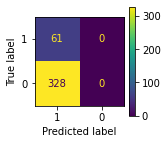

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.157,1.000,0.271,0.157,0.659,0.134


In [15]:
print("############### Results without encoding ##############")
results2     = train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list)

############### Results encoded data ##############
Best: 0.543182 using {'class_weight': {1: 25}}
AUC    (call)
0.619969 (0.000000) with: {'class_weight': {1: 1}}
0.652110 (0.003030) with: {'class_weight': {1: 2}}
0.686151 (0.159848) with: {'class_weight': {1: 3}}
0.696166 (0.284848) with: {'class_weight': {1: 4}}
0.693091 (0.341919) with: {'class_weight': {1: 5}}
0.688245 (0.467424) with: {'class_weight': {1: 8}}
0.683591 (0.506818) with: {'class_weight': {1: 10}}
0.681104 (0.543182) with: {'class_weight': {1: 25}}
0.681104 (0.543182) with: {'class_weight': {1: 50}}
0.681104 (0.543182) with: {'class_weight': {1: 75}}
0.681104 (0.543182) with: {'class_weight': {1: 99}}
0.681104 (0.543182) with: {'class_weight': {1: 100}}
0.681104 (0.543182) with: {'class_weight': {1: 500}}

time elapased training:  32.18191361427307


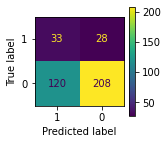

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.216,0.541,0.308,0.620,0.632,0.130


In [16]:
print("############### Results encoded data ##############")
results2_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, X_train_set, X_valid_set, grid, feat_list)

# CURB65 Group 3

In [17]:
X_train_set = X_data_16_18[2]
X_valid_set = X_data_19_20[2]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1095
total admissions 19 20 259
X_train 1095
Admissions neg (mortal - class = 0): 898 Admissions pos (recover- class = 1): 197
X_valid 259
Admissions neg (mortal - class = 0): 206 Admissions pos (recover- class = 1): 53

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,79958796,22.000,8,91.000,36.300,140.000,57.000,90.000,1.000,0,-1,0,79,8,0,0.000,1
144,54340823,38.000,7,95.000,36.100,136.000,88.000,94.000,1.000,0,-1,0,91,0,1,1.000,1
288,53145905,22.000,5,74.000,37.000,93.000,47.000,95.000,1.000,1,-1,0,90,3,0,1.000,0
432,68698350,26.000,10,85.000,35.000,81.000,58.000,95.000,1.000,1,-1,0,80,2,1,0.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.258,0.156,-0.089,-0.945,0.867,-0.652,-1.072,1.000,0,-1,0.177,-0.259,0.484,0,0.000
144,2.466,0.178,0.102,-1.170,0.694,1.353,-0.107,1.000,0,-1,0.177,1.111,-0.978,1,1.000
288,-0.258,0.172,-0.900,-0.157,-1.173,-1.298,0.134,1.000,1,-1,0.177,0.997,-0.430,0,1.000
432,0.423,0.216,-0.375,-2.407,-1.694,-0.587,0.134,1.000,1,-1,0.177,-0.145,-0.613,1,0.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,59603192,26.000,6,77.000,38.100,145.000,55.000,96.000,1.000,0,-1,0,84,12,0,1.000,0
144,33386907,18.000,1,87.000,36.700,129.000,75.000,95.000,0.000,0,1,0,88,3,1,0.000,0
288,80377128,22.000,6,87.000,36.200,100.000,71.000,96.000,1.000,0,1,0,84,4,1,1.000,1
432,26956465,24.000,3,91.000,36.800,116.000,49.000,100.000,0.000,0,1,11,94,0,0,0.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,0.423,0.226,-0.757,1.080,1.084,-0.781,0.375,1.000,0,-1,0.177,0.312,1.216,0,1.000
144,-0.939,0.152,-0.279,-0.495,0.390,0.512,0.134,0.000,0,1,0.177,0.769,-0.430,1,0.000
288,-0.258,0.226,-0.279,-1.057,-0.869,0.253,0.375,1.000,0,1,0.177,0.312,-0.247,1,1.000
432,0.083,0.191,-0.089,-0.382,-0.174,-1.169,1.340,0.000,0,1,0.000,1.454,-0.978,0,0.000


,feature,type,parameters
0,rr,Continuous,"[23.515068493150686, 5.875031710199772]"
1,ews,Categorical,0 1 prob 8 76 14 0.156 7 97 2...
2,heart_rate,Continuous,"[92.85433789954338, 20.9473422872334]"
3,temperature,Continuous,"[37.14, 0.8890729103137421]"
4,sbp,Continuous,"[120.01689497716895, 23.03723711349762]"
5,dbp,Continuous,"[67.08155251141552, 15.465202650373554]"
6,Oxygen_Saturation,Continuous,"[94.44337899543379, 4.1460416462531064]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############
Best: 1.000000 using {'class_weight': {1: 10}}
AUC    (call)
0.628637 (0.000000) with: {'class_weight': {1: 1}}
0.664861 (0.000000) with: {'class_weight': {1: 2}}
0.658482 (0.000000) with: {'class_weight': {1: 3}}
0.666609 (0.585263) with: {'class_weight': {1: 4}}
0.668406 (0.738947) with: {'class_weight': {1: 5}}
0.665436 (0.994912) with: {'class_weight': {1: 8}}
0.664108 (1.000000) with: {'class_weight': {1: 10}}
0.649540 (1.000000) with: {'class_weight': {1: 25}}
0.600536 (1.000000) with: {'class_weight': {1: 50}}
0.593695 (1.000000) with: {'class_weight': {1: 75}}
0.593252 (1.000000) with: {'class_weight': {1: 99}}
0.593252 (1.000000) with: {'class_weight': {1: 100}}
0.593252 (1.000000) with: {'class_weight': {1: 500}}

time elapased training:  46.28362846374512


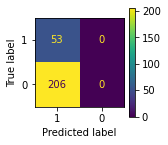

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.205,1.000,0.340,0.205,0.653,0.156


In [18]:
print("############### Results without encoding ##############")
results3     = train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list)

############### Results encoded data ##############
Best: 0.694386 using {'class_weight': {1: 25}}
AUC    (call)
0.600092 (0.000000) with: {'class_weight': {1: 1}}
0.640368 (0.116404) with: {'class_weight': {1: 2}}
0.652514 (0.362368) with: {'class_weight': {1: 3}}
0.644625 (0.447281) with: {'class_weight': {1: 4}}
0.641033 (0.525526) with: {'class_weight': {1: 5}}
0.626852 (0.654123) with: {'class_weight': {1: 8}}
0.621709 (0.675877) with: {'class_weight': {1: 10}}
0.618003 (0.694386) with: {'class_weight': {1: 25}}
0.618190 (0.694386) with: {'class_weight': {1: 50}}
0.618190 (0.694386) with: {'class_weight': {1: 75}}
0.618190 (0.694386) with: {'class_weight': {1: 99}}
0.618190 (0.694386) with: {'class_weight': {1: 100}}
0.618190 (0.694386) with: {'class_weight': {1: 500}}

time elapased training:  40.60031867027283


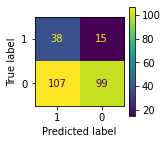

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.262,0.717,0.384,0.529,0.617,0.160


In [19]:
print("############### Results encoded data ##############")
results3_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, X_train_set, X_valid_set, grid, feat_list)

# Results

# AUROC curve

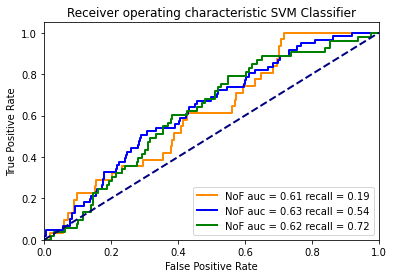

In [20]:
title = 'SVM Classifier'
plt.figure()
colors = ['darkorange', 'b','g','r','c', 'm']
i = 0

results_encs =[results1_enc, results2_enc, results3_enc]

for results_enc in results_encs:

    df_results_valid = results_enc[1]
    dict_fpr_tpr     = results_enc[2]

    key = 'NoF'
    val = dict_fpr_tpr[key]
    auc = df_results_valid.loc[key,'AUC']
    rcl = df_results_valid.loc[key,'Recall']
    fpr, tpr = val

    lw = 2

    plt.plot(fpr,  tpr,  color= colors[i],  lw=lw,label= key + " auc = {:,.2f} recall = {:,.2f}".format(auc, rcl) 
        #label="ROC curve (area = %0.2f)" % metrics.roc_auc[2],
    )
    i = i + 1
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic "+ title)
plt.legend(loc="lower right")
#plt.savefig('AUROC_'+title+'.png', transparent = True, bbox_inches = "tight")
plt.show()

In [21]:
pickle.dump([results_encs], open('dict_fpr_trp_'+title+'.pickle', 'wb'))

In [22]:
for r in results_encs:
    display(r[1])

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.146,0.194,0.167,0.853,0.611,0.070


,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.216,0.541,0.308,0.620,0.632,0.130


,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.262,0.717,0.384,0.529,0.617,0.160
